In [ ]:
#! pip install albumentations==0.4.6


#from collections import defaultdict
#import copy
import random
import os
#import shutil
#from urllib.request import urlretrieve

'''
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch.transforms  import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
#import ternausnet.models
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision
%load_ext tensorboard
import torch.nn.functional as f
cudnn.benchmark = True
#torch.cuda.empty_cache()
'''



! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import zipfile
zf = "../coronahack-chest-xraydataset.zip"
target_dir = "../Dataset"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np              
import pandas as pd   
import torchvision.transforms as transforms

#Define Directories for train, test & Validation Set
train_path = '../Dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_path = '../Dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'


batch_size = 16 

img_width = 500

Import Useful Libraries

In [ ]:
import random
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import torchvision

Split Training Dataset into Train and Validation

In [ ]:
# Files paths
#train_path = './Dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
#test_path = './Dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
meta_file_dir = './Dataset/Chest_xray_Corona_Metadata.csv'

missed = []
data_path = './Dataset/Tr_Test_Data'
data_images_filenames = set(os.listdir(data_path))
# Remove missed data from dataset
meta_data = pd.read_csv(meta_file_dir, usecols=['X_ray_image_name', 'Label', 'Label_2_Virus_category', 'Label_1_Virus_category'])    # Read the meta_data csv file
meta_names = meta_data.X_ray_image_name.to_list()                               # List of image names  
for image_name in data_images_filenames:                                        # Apply this for all data
    if image_name not in meta_names:                                            # Check whether image name is in meta file
      missed.append(image_name)

data_images_filenames = sorted(list(data_images_filenames))
for i in missed:
  data_images_filenames.remove(i)

# PREPARE THE LABELS FOR EACH CLASS
data_df = pd.read_csv(meta_file_dir)
data_df['Label_2_Virus_category'].fillna('NA', inplace=True)                    # Fill nan values with 'NA' in csv file
# Get indexes of each case
idx_normal = data_df[data_df['Label'] == 'Normal'].index                        
idx_ards = data_df[data_df['Label_2_Virus_category'] == 'ARDS'].index
idx_covid = data_df[data_df['Label_2_Virus_category'] == 'COVID-19'].index
idx_sars = data_df[data_df['Label_2_Virus_category'] == 'SARS'].index
idx_streptococcus = data_df[data_df['Label_2_Virus_category'] == 'Streptococcus'].index
idx_virus_NaN = data_df[(data_df['Label_1_Virus_category'] == 'Virus') & (data_df['Label_2_Virus_category'] == 'NA')].index
idx_bacteria_NaN = data_df[(data_df['Label_1_Virus_category'] == 'bacteria') & (data_df['Label_2_Virus_category'] == 'NA')].index

# Get image names of specified indexes, obtain list of image names, obtain dict of image names with corresponding labels
normal_case = data_df['X_ray_image_name'][idx_normal]
normal_case = normal_case.to_list()
normal_case = {normal_case[i]:0 for i in range(len(normal_case))}

# Merge viruses into one category
covid_case = data_df['X_ray_image_name'][idx_covid]
covid_case = covid_case.to_list()
sars_case = data_df['X_ray_image_name'][idx_sars]
sars_case = sars_case.to_list()
virus_nan = data_df['X_ray_image_name'][idx_virus_NaN]
virus_nan = virus_nan.to_list()
viruses = covid_case + sars_case + virus_nan
virus = {viruses[i]:1 for i in range(len(viruses))}

# Merge bacterias into one category
bacteria_nan = data_df['X_ray_image_name'][idx_bacteria_NaN]
bacteria_nan = bacteria_nan.to_list()
streptococcus_case = data_df['X_ray_image_name'][idx_streptococcus]
streptococcus_case = streptococcus_case.to_list()
bacterias = bacteria_nan + streptococcus_case
bacteria = {bacterias[i]:2 for i in range(len(bacterias))}

ards_case = data_df['X_ray_image_name'][idx_ards]
ards_case = ards_case.to_list()


# Merge all the dictinaries into one dict
labelled_data = {**normal_case, **virus, **bacteria}

# Remove ards case from dataset
for i in ards_case:
  data_images_filenames.remove(i)

# Randomly create train/val/test dataset
random.seed(42)
random.shuffle(data_images_filenames)                        # Shuffle all the images in order to randmoly create train/val/test dataset

train_images_filenames = data_images_filenames[:4726]        # 80% train images
val_images_filenames = data_images_filenames[4726:-591]      # 10% val images 
test_images_filenames = data_images_filenames[-591:]         # 10% test images




print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))
print(len(missed), len(data_images_filenames), len(meta_names))

4726 591 591
23 5908 5910


Dataset Preparation

In [ ]:
class ChestDataset(Dataset):
    def __init__(self, images_filenames, images_directory, labelled_data, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory 
        self.labelled_data = labelled_data
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_name = self.images_filenames[idx]
        #image = cv2.imread(os.path.join(self.images_directory, image_name), cv2.IMREAD_GRAYSCALE)     
        image = Image.open(os.path.join(self.images_directory, image_name))     # Read an image as PIL image
        image = image.convert("RGB")
        label = self.labelled_data[image_name]
           
        if self.transform is not None:
            image = self.transform(image)
            
        return image, torch.tensor(label)



# Transformations
train_transforms = transforms.Compose([
                                                         # Convert the images into grayscale
                                  transforms.Resize((224,224)),
                                  #transforms.RandomCrop((225,225)),
                                  transforms.ColorJitter(),
                                  transforms.RandomRotation(degrees=25),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  #transforms.RandomVerticalFlip(p=0.5),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            # Be sure of these values!!!                          
])

# Augmentation is not applied to the validation dataset
validation_transforms = transforms.Compose([
                                            transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                    
])

# Create datasets
train_dataset = ChestDataset(train_images_filenames, data_path, labelled_data, transform=train_transforms)
validation_dataset = ChestDataset(val_images_filenames, data_path, labelled_data, transform=validation_transforms)
test_dataset = ChestDataset(test_images_filenames, data_path, labelled_data, transform=test_transforms)

In [ ]:
import pandas as pd
meta_file_dir = './Dataset/Chest_xray_Corona_Metadata.csv'
#tr_data = './Dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

data_path = './Dataset/Tr_Test_Data'
data_images_filenames = set(os.listdir(data_path))
missed_tr = []
meta_data = pd.read_csv(meta_file_dir, usecols=['X_ray_image_name', 'Label', 'Label_2_Virus_category', 'Label_1_Virus_category'])    # Read the meta_data csv file
meta_names = sorted(meta_data.X_ray_image_name.to_list())                               # List of image names  
for image_name in data_images_filenames:                                        # Apply this for all data
    if image_name not in meta_names:                                            # Check whether image name is in meta file
      #data_images_filenames.remove(image_name)
      missed_tr.append(image_name)
data_images_filenames = sorted(list(data_images_filenames))
for i in missed_tr:
  data_images_filenames.remove(i)


data_df = pd.read_csv(meta_file_dir)
data_df['Label_2_Virus_category'].fillna('NA', inplace=True)
Normal_data = [data_df['Label'] == 'Normal']

idx_normal = data_df[data_df['Label'] == 'Normal'].index

idx_ards = data_df[data_df['Label_2_Virus_category'] == 'ARDS'].index
idx_covid = data_df[data_df['Label_2_Virus_category'] == 'COVID-19'].index
idx_sars = data_df[data_df['Label_2_Virus_category'] == 'SARS'].index
idx_streptococcus = data_df[data_df['Label_2_Virus_category'] == 'Streptococcus'].index
idx_virus_NaN = data_df[(data_df['Label_1_Virus_category'] == 'Virus') & (data_df['Label_2_Virus_category'] == 'NA')].index
idx_bacteria_NaN = data_df[(data_df['Label_1_Virus_category'] == 'bacteria') & (data_df['Label_2_Virus_category'] == 'NA')].index
normal_case = data_df['X_ray_image_name'][idx_normal]

In [ ]:
normal_case = normal_case.to_list()
normal_case = {normal_case[i]:0 for i in range(len(normal_case))}

ards_case = data_df['X_ray_image_name'][idx_ards]
ards_case = ards_case.to_list()
ards_case = {ards_case[i]:1 for i in range(len(ards_case))}

covid_case = data_df['X_ray_image_name'][idx_covid]
covid_case = covid_case.to_list()
covid_case = {covid_case[i]:3 for i in range(len(covid_case))}

sars_case = data_df['X_ray_image_name'][idx_sars]
sars_case = sars_case.to_list()
sars_case = {sars_case[i]:4 for i in range(len(sars_case))}

streptococcus_case = data_df['X_ray_image_name'][idx_streptococcus]
streptococcus_case = streptococcus_case.to_list()
streptococcus_case = {streptococcus_case[i]:6 for i in range(len(streptococcus_case))}

virus_nan = data_df['X_ray_image_name'][idx_virus_NaN]
virus_nan = virus_nan.to_list()
virus_nan = {virus_nan[i]:2 for i in range(len(virus_nan))}

bacteria_nan = data_df['X_ray_image_name'][idx_bacteria_NaN]
bacteria_nan = bacteria_nan.to_list()
bacteria_nan = {bacteria_nan[i]:5 for i in range(len(bacteria_nan))}

labelled_data = {**normal_case, **ards_case, **virus_nan, **covid_case, **sars_case, **bacteria_nan, **streptococcus_case}

###Models

Simple Model(Corona Net)

In [ ]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)



#double 3x3 convolutions 
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3,padding=1),  # padding=1 was added
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),                                                    # inplace= True ---> Can be used as well.
        nn.Dropout(p=0.8),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
            )
    conv.apply(init_weights)
    return conv


class Corona_Net(nn.Module):
  def __init__(self, in_channel=1, out_channel=32):
    super(Corona_Net, self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
        #nn.Dropout2d(p=0.1, inplace=False),
        #nn.MaxPool2d(kernel_size=2,stride=2),            #
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
        #nn.Dropout2d(p=0.1, inplace=False),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
        #nn.Dropout2d(p=0.2, inplace=False),
        #nn.MaxPool2d(kernel_size=2,stride=2),            #
        nn.Conv2d(out_channel, 64, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        #nn.Dropout2d(p=0.3, inplace=False),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(64, 64, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        #nn.Dropout2d(p=0.4, inplace=False),
        #nn.MaxPool2d(kernel_size=2,stride=2),            #
        nn.Conv2d(64, 128, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.conv.apply(init_weights)

    
    
    self.linear = nn.Sequential(
        nn.Linear(128*5*5,128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 7) )                         # The number of classes is 7
    self.linear.apply(init_weights)
  
  def forward(self, image):
    
    out = self.conv(image)

    out = out.view(-1, 128*5*5)                    # Flattening the conv output

    out = self.linear(out)

    return out


if __name__ == '__main__':
    image = torch.rand((1, 1, 500, 500))
    model = Corona_Net()
    print(model(image).size())
  
    #summary(model, (1,500,500))







torch.Size([1, 7])


Corona_ResNet

ResNet18

In [ ]:
import torchvision

def freeze_some_parameters(model):

  for i, child in enumerate(model):
    if i < 6:                     # Set the ith layer and freeze all the layers up to the ith layer
      for param in child.parameters():
        param.requires_grad = False

resnet = torchvision.models.resnet18(pretrained=True)
num_filters = resnet.fc.in_features
resnet.fc = nn.Linear(num_filters, 3)
#vgg.features._modules["0"] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_layers = list(resnet.children())
freeze_some_parameters(model_layers)

if __name__ == '__main__':
    image = torch.rand((1, 3, 500, 500))
    model = resnet
    #print(model(image).size())
model_layers[7]

###Train and Evaluate

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    
    model.train()
    running_loss = 0.0
    total = 0.
    correct = 0.
    for i, (images, target) in enumerate(train_loader):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)
        loss = criterion(output, target)
        #loss = loss_with_reg(output, target, model, criterion)                             # L2 Regularization
        
        #del output, images, target  
        
        running_loss += float(loss.item()) * images.size(0)            # loss.item() returns the average loss for each sample within the batch
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted==target).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('training loss',
                            running_loss / len(train_loader.dataset), epoch)
        
    epoch_acc = 100 * correct / total      
    epoch_loss = running_loss / len(train_loader.dataset)
    print('Epoch: {}, Tr_Loss: {}, Tr_Acc: {}'.format(epoch, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc 

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    
    model.eval()
    
    running_loss = 0.0
    total = 0.
    correct = 0.
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            loss = criterion(output, target)
            #loss = loss_with_reg(output, target, model, criterion)                         # L2 Regularization
            #del output, images, target 
            
            running_loss += float(loss.item()) * images.size(0)                 # val_loader.batch_size
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted==target).sum().item()            
            writer.add_scalar('validation loss', 
                            running_loss / len(val_loader.dataset), epoch)
            
    epoch_loss = running_loss / len(val_loader.dataset)
    
    epoch_acc = 100 * correct / total
    print('Epoch: {}, Val_Loss: {}, Val_Acc: {}'.format(epoch, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc 

In [ ]:
def create_model(params):
    model = params["model"]  
    model = model.to(params["device"])
    return model

'''
# Custom collate_fn function
def collate_fn(data):
    res = tuple(zip(*data))
    #print(res[0][0].shape, res[1][0].shape)
    return res
'''

'''
# Add L2 Regularization
def loss_with_reg(out, predict, model, criteria):
  reg = 0.0
  reg_lambda = 5e-2
  for p in model.parameters():
    reg += 0.5 * (p**2).sum()
  loss = criteria(out, predict) + reg_lambda * reg
  return loss
'''
# Weighting the classes(for solving class imbalance in dataset)
nSamples = torch.tensor([1277, 1234, 2215])
class_weights = (1.0 - nSamples / nSamples.sum()).to('cuda')
#class_weights = (1.0 / nSamples) * 2777 


def train_and_validate(model, train_dataset, validation_dataset, params, weights):
    train_loss = [] 
    valid_loss = []
    valid_acc = []
    train_acc = []
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
        #collate_fn=collate_fn 
    )
    val_loader = DataLoader(
        validation_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
        #collate_fn = collate_fn
    )
   
    criterion = nn.CrossEntropyLoss(weight=weights).to(params["device"]) 
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])    # with L2 regularization
    scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)            # lr scheduler
    for epoch in range(params["epochs"]):
        tr_loss, tr_acc = train(train_loader, model, criterion, optimizer, epoch, params)
        val_loss, val_acc = validate(val_loader, model, criterion, epoch, params)
        scheduler.step()
        
        train_loss.append(tr_loss)
        train_acc.append(tr_acc)
        valid_loss.append(val_loss)
        valid_acc.append(val_acc)
        
    
    
    stat = {'val_loss':valid_loss, 'tr_loss':train_loss, 'val_acc':valid_acc, 'tr_acc':train_acc} 
    
    return model, stat


###Test the Model

Test Accuracy = 80.5414551607445 %
Confusion Matrix:  [[150   6   4]
 [  7 100  47]
 [  8  43 226]]
Report:                precision    recall  f1-score   support

           0       0.91      0.94      0.92       160
           1       0.67      0.65      0.66       154
           2       0.82      0.82      0.82       277

    accuracy                           0.81       591
   macro avg       0.80      0.80      0.80       591
weighted avg       0.80      0.81      0.80       591



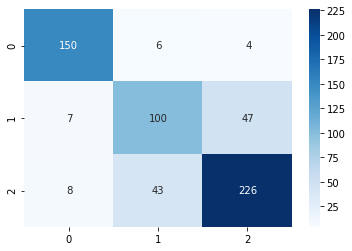

In [ ]:
model.eval()
total = 0.
correct = 0.
predict = []
actual = []

test_loader = DataLoader(
        test_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True)

with torch.no_grad():
    predictions = torch.tensor([]).cuda()
    targets = torch.tensor([]).cuda()
    for data in test_loader:
        img, label = data
        img = img.cuda()
        label = label.cuda()
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted==label).sum().item()
        predictions = torch.cat((predictions, predicted), dim=0)
        targets = torch.cat((targets, label), dim=0)
    test_acc = 100 * correct / total
    cf_matrix = confusion_matrix(targets.cpu(), predictions.cpu(), labels=[0,1,2])
    report = classification_report(targets.cpu(),predictions.cpu(), labels=[0,1,2])  
print('Test Accuracy = {} %'.format(test_acc))
print('Confusion Matrix: ', cf_matrix)
print('Report: ', report)
sns.heatmap(cf_matrix, fmt='2', annot=True, cmap='Blues') # fmt='.2%'

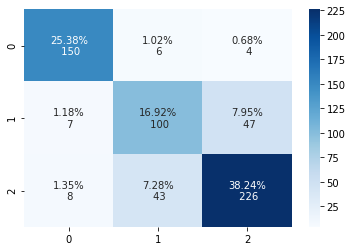

In [ ]:
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n {v2}' for v1, v2 in
          zip(group_percentages, group_counts)]
    
labels = np.asarray(labels).reshape(3,3)
s_plot = sns.heatmap(cf_matrix, fmt='2', annot=labels, cmap='Blues') # fmt='.2%'
fig = s_plot.get_figure()
fig.savefig('./ResNet_3Class_Cmatrix')


###Prediction

In [ ]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions


In [ ]:
params = {
    "model":resnet,
    "device": "cuda",
    "lr": 1e-5,
    "batch_size": 128,
    "num_workers": 4,
    "epochs": 20,
    "weight_decay":0
}


In [ ]:
from torch.utils.tensorboard import SummaryWriter

#Create Tensorboard
writer = SummaryWriter('runs/my_experiment72')

# Create and Train a model
model = create_model(params)
model, stat = train_and_validate(model, train_dataset, validation_dataset, params, class_weights)

writer.flush()
writer.close()

Epoch: 0, Tr_Loss: 0.9764775983923025, Tr_Acc: 41.832416419805334
Epoch: 0, Val_Loss: 0.8716697133132044, Val_Acc: 45.346869712351946
Epoch: 1, Tr_Loss: 0.6183790409913065, Tr_Acc: 72.66187050359713
Epoch: 1, Val_Loss: 0.6128133420411706, Val_Acc: 71.2351945854484
Epoch: 2, Tr_Loss: 0.5363128480899148, Tr_Acc: 77.80363944138807
Epoch: 2, Val_Loss: 0.5703030978967696, Val_Acc: 75.46531302876481
Epoch: 3, Tr_Loss: 0.5035771587315727, Tr_Acc: 79.64451967837495
Epoch: 3, Val_Loss: 0.5277081508120103, Val_Acc: 77.834179357022
Epoch: 4, Tr_Loss: 0.48913653962348813, Tr_Acc: 80.80829454083792
Epoch: 4, Val_Loss: 0.5179957195788673, Val_Acc: 78.84940778341793
Epoch: 5, Tr_Loss: 0.46481473537708207, Tr_Acc: 81.54887854422344
Epoch: 5, Val_Loss: 0.48866638536178925, Val_Acc: 79.69543147208122
Epoch: 6, Tr_Loss: 0.4545794048780513, Tr_Acc: 81.44308082945409
Epoch: 6, Val_Loss: 0.48209076423935476, Val_Acc: 80.20304568527919
Epoch: 7, Tr_Loss: 0.44444636446260266, Tr_Acc: 81.8874312314854
Epoch: 7

In [ ]:
# Save the model weights
torch.save(model.state_dict(), './ResNet18_3Class_.ckpt')

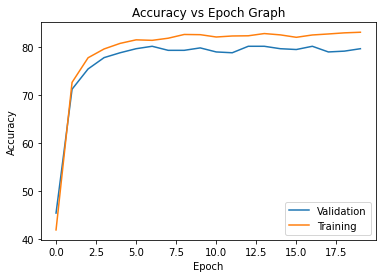

In [ ]:
tr_loss = stat['tr_acc']
val_loss = stat['val_acc']
plt.plot(val_loss, label='Validation')
plt.plot(tr_loss, label='Training')
plt.title('Accuracy vs Epoch Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#print(val_loss[-1])